In [250]:
import pandas as pd
import seaborn as sns
import numpy as np
import os.path
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import power_transform, MinMaxScaler, StandardScaler
from imblearn import under_sampling, over_sampling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

linux_dir = '/home/satan/Projects/Dataset/HCI/home-credit-default-risk/'
win_dir = 'D:/Projects/Dataset/HCI/home-credit-default-risk/'

In [251]:
def kdeplot_me(df, columns, hue=None, figsize=(30, 15)):
    plt.figure(figsize=figsize)
    for col_name, index in zip(columns, range(len(columns))):
        plt.subplot( int(len(columns)/6)+1  , 6, index+1)
        if hue != None:
            sns.kdeplot(data=df, x=col_name, hue=hue, color='green', linewidth=3, fill=True)
        else:
            sns.kdeplot(data=df, x=col_name, color='green', linewidth=3, fill=True)
        plt.xlabel(col_name)
    plt.show()

def violinplot_me(df, columns, hue=None, figsize=(30, 15)):
    plt.figure(figsize=figsize)
    for col_name, index in zip(columns, range(len(columns))):
        plt.subplot( int(len(columns)/6)+1  , 6, index+1)
        if hue != None:
            sns.violinplot(data=df, x=col_name, hue=hue, color='green', linewidth=3, fill=True)
        else:
            sns.violinplot(data=df, x=col_name, color='green', linewidth=3, fill=True)
        plt.xlabel(col_name)
    plt.show()
    
def boxplot_me(df, columns, x, figsize=(30, 15)):
    plt.figure(figsize=figsize)
    for col_name, index in zip(columns, range(len(columns))):
        plt.subplot( int(len(columns)/6)+1  , 6, index+1)
        sns.boxplot(data=df, x=x, y=col_name)
        plt.xlabel(col_name)
    plt.show()
       
def log_transform(temp_df, log_columns):
    for col in log_columns:
        if temp_df[col].min() == 0:
            # df[col] = np.log(df[col]+1)
            temp_df[col], fitted_lambda = stats.boxcox( ( temp_df[col] + 1) )
        elif temp_df[col].min() > 0:
            # df[col] = np.log(df[col])
            temp_df[col], fitted_lambda = stats.boxcox( temp_df[col] )
        else:
            # df[col] = np.log(df[col])
            margin = 1 - temp_df[col].min()
            temp_df[col], fitted_lambda = stats.boxcox( temp_df[col] + margin)


def get_minmax_scaler(temp_df, columns):
    scaler = {}
    for col in columns:
        scaler[col] = MinMaxScaler().fit( np.array(temp_df[col]).reshape(-1,1) )
    return scaler

def get_standard_scaler(temp_df, columns):
    scaler = {}
    for col in columns:
        scaler[col] = StandardScaler().fit( np.array(temp_df[col]).reshape(-1,1) )
    return scaler

def apply_transform(scaler, temp_df):
    tmp_df = temp_df.copy()
    for col in scaler.keys():
        tmp_df[col] = scaler[col].transform( np.array(temp_df[col]).reshape(-1,1) )
    return tmp_df

In [252]:
try :
    app_train = pd.read_csv(linux_dir+'application_train.csv')
    # app_test = pd.read_csv(linux_dir+'application_test.csv')
except:
    app_train = pd.read_csv(win_dir+'application_train.csv')
    # app_test = pd.read_csv(win_dir+'application_test.csv')
app_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307233 non-null  float64
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

In [253]:
app_cat_var = app_train.columns[app_train.dtypes == 'object'].tolist()
for col in app_cat_var:
    print(col,'\n',app_train[col].value_counts(),'\n')

NAME_CONTRACT_TYPE 
 Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64 

CODE_GENDER 
 F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64 

FLAG_OWN_CAR 
 N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64 

FLAG_OWN_REALTY 
 Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64 

NAME_TYPE_SUITE 
 Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64 

NAME_INCOME_TYPE 
 Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64 

NAME_EDUCATION_TYPE 
 Secondary / secondary special    218391
Higher education                  74

count    306490.000000
mean          0.100049
std           0.362291
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          24.000000
Name: DEF_60_CNT_SOCIAL_CIRCLE, dtype: float64

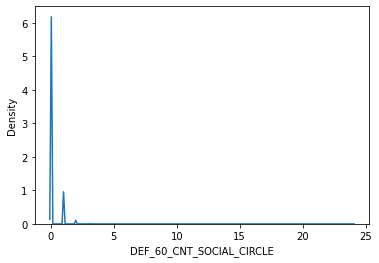

In [254]:
excluded_features = ['ORGANIZATION_TYPE','NAME_TYPE_SUITE','FLAG_OWN_CAR','WALLSMATERIAL_MODE']

sns.kdeplot(app_train['DEF_60_CNT_SOCIAL_CIRCLE'])
(app_train['DEF_60_CNT_SOCIAL_CIRCLE']).describe()

In [255]:
temp_df = app_train.copy()

temp_df.OWN_CAR_AGE.fillna(0, inplace=True)
temp_df.loc[ temp_df.FLAG_OWN_CAR == 'N', 'OWN_CAR_AGE' ] = -1

temp_df.drop(index=temp_df[(temp_df.NAME_FAMILY_STATUS=='Unknown')|(temp_df.CODE_GENDER=='XNA')|(temp_df.NAME_INCOME_TYPE=='Maternity leave')].index, inplace=True)

temp_df = temp_df[ [col for col in app_train.columns if col not in excluded_features] ]

app_cat_var = temp_df.columns[temp_df.dtypes == 'object'].tolist()

# for index, values in temp_df.dtypes.items():
#     if values == 'object':
#         temp_df[index] = temp_df[index].fillna(temp_df[index].mode())
#     else:
#         temp_df[index] = temp_df[index].fillna(temp_df[index].median())

# app_cat_binary = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_REALTY','FLAG_OWN_CAR','EMERGENCYSTATE_MODE']
app_cat_binary = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_REALTY','EMERGENCYSTATE_MODE']
app_cat_multi = [col for col in app_cat_var if col not in app_cat_binary + ['NAME_EDUCATION_TYPE']]
edu_map = {'Lower secondary':0, 'Secondary / secondary special': 1, 'Incomplete higher':2, 'Higher education':3, 'Academic degree':4}
# days_map = {'MONDAY':0, 'TUESDAY': 1, 'WEDNESDAY':2, 'THURSDAY':3, 'FRIDAY':4, 'SATURDAY':5, 'SUNDAY':6}


for col in app_cat_binary:
    temp_dict = dict([ [i,j] for i,j in zip(temp_df[col].value_counts().index.to_list(),[0,1])])
    temp_df[col] = temp_df[col].map(temp_dict)
    
temp_df['NAME_EDUCATION_TYPE'] = temp_df['NAME_EDUCATION_TYPE'].map(edu_map) 
temp_df['AGE'] = -1*temp_df['DAYS_BIRTH']/365
# temp_df['YEARS_EMPLOYED'] = -1*temp_df['DAYS_EMPLOYED']/365

temp_df = pd.get_dummies(temp_df, columns=app_cat_multi, drop_first=True)

temp_df.replace([np.inf, -np.inf], np.nan, inplace=True)
temp_df.dropna(axis=0,inplace=True)
temp_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31232 entries, 0 to 307482
Data columns (total 155 columns):
 #    Column                                    Non-Null Count  Dtype  
---   ------                                    --------------  -----  
 0    SK_ID_CURR                                31232 non-null  int64  
 1    TARGET                                    31232 non-null  int64  
 2    NAME_CONTRACT_TYPE                        31232 non-null  int64  
 3    CODE_GENDER                               31232 non-null  int64  
 4    FLAG_OWN_REALTY                           31232 non-null  int64  
 5    CNT_CHILDREN                              31232 non-null  int64  
 6    AMT_INCOME_TOTAL                          31232 non-null  float64
 7    AMT_CREDIT                                31232 non-null  float64
 8    AMT_ANNUITY                               31232 non-null  float64
 9    AMT_GOODS_PRICE                           31232 non-null  float64
 10   NAME_EDUCATION_TYPE

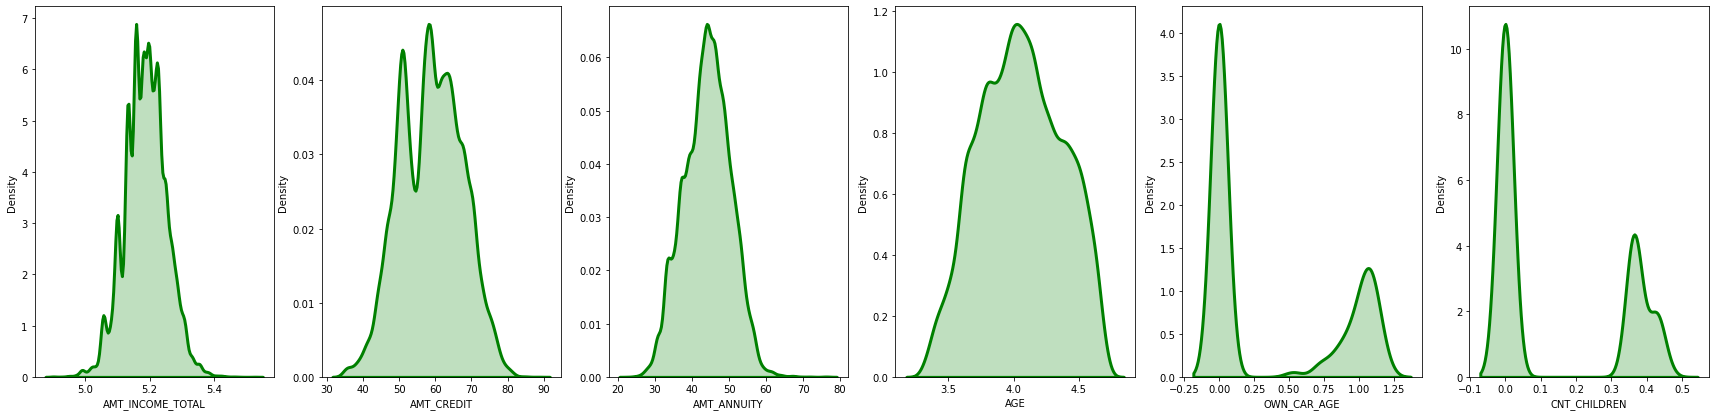

In [256]:
observed_features = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AGE','OWN_CAR_AGE','CNT_CHILDREN']

log_transform(temp_df, ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AGE','OWN_CAR_AGE','CNT_CHILDREN'])
kdeplot_me(temp_df, observed_features)

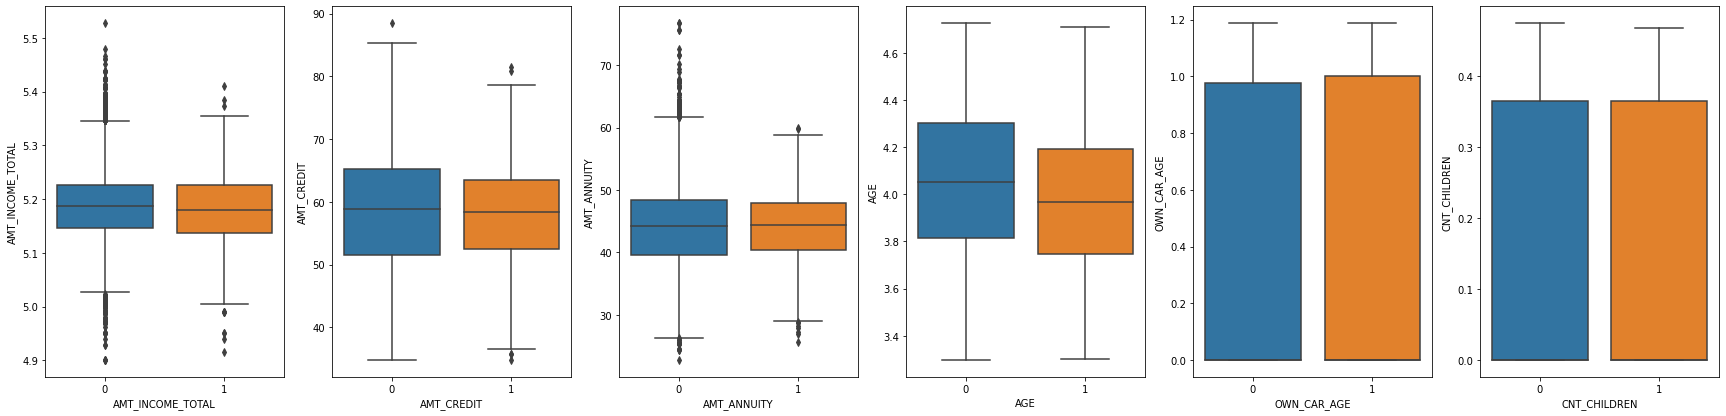

In [257]:
boxplot_me(temp_df, observed_features, 'TARGET')

In [258]:
var_columns = [col for col in temp_df.columns if col != 'TARGET']
x, y = temp_df[var_columns].copy(), temp_df.TARGET.copy()
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)
ytrain.value_counts(), ytrain.value_counts(normalize=True)*100

(0    20433
 1     1429
 Name: TARGET, dtype: int64,
 0    93.463544
 1     6.536456
 Name: TARGET, dtype: float64)

In [270]:
len(xtrain), len(xtest)

(21862, 9370)

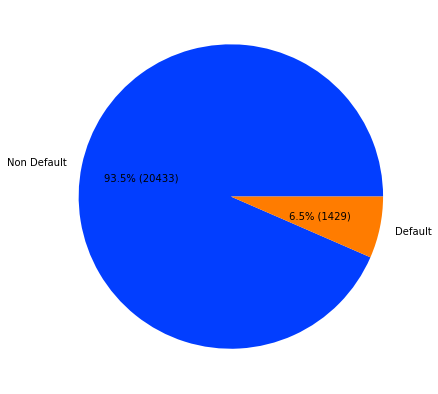

In [259]:
# temp_test = pd.concat([xtest, ytest], axis=1)
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}% ({v:d})'.format(p=pct,v=val)
    return my_autopct
plt.figure(figsize=(7,7))
plt.pie( ytrain.value_counts().values , labels=['Non Default','Default'], colors=sns.color_palette('bright'), autopct=make_autopct(ytrain.value_counts().values))
plt.show()

In [260]:
scaler = get_minmax_scaler(xtrain, xtrain.columns)
xtrain = apply_transform(scaler, xtrain)
xtest = apply_transform(scaler, xtest)

In [261]:
# xtrain.info(verbose=True, show_counts=True)

In [262]:
xtrain_balance, ytrain_balance = xtrain.copy(), ytrain.copy()
xtrain_balance, ytrain_balance = over_sampling.SMOTE().fit_resample(xtrain_balance, ytrain_balance)
ytrain_balance.value_counts()

0    20433
1    20433
Name: TARGET, dtype: int64

# **Modeling**

In [286]:
def eval_classification(model, xtrain, ytrain, xtest, ytest, threshold=0.5):
    ypred_proba_test = model.predict_proba(xtest)
    ypred_proba_train = model.predict_proba(xtrain)
    ypred_test = np.where(ypred_proba_test[:,1]>threshold, 1, 0 )
    ypred_train = np.where(ypred_proba_train[:,1]>threshold, 1, 0 )
    cm = confusion_matrix(ytest, ypred_test)
    print("Accuracy (Test) : %.2f" % accuracy_score(ytest, ypred_test))
    print("Accuracy (Train) : %.2f" % accuracy_score(ytrain, ypred_train))
    print("Precision (Test) : %.2f" % precision_score(ytest, ypred_test))
    print("Precision (Train) : %.2f" % precision_score(ytrain, ypred_train))
    print("Recall (Test) : %.2f" % recall_score(ytest, ypred_test))
    print("Recall (Train) : %.2f" % recall_score(ytrain, ypred_train))
    print("F1-Score (Test) : %.2f" % f1_score(ytest, ypred_test))
    print("F1-Score (Train) : %.2f" % f1_score(ytrain, ypred_train))
    print("ROC_AUC (test-proba) : %.2f" % roc_auc_score(ytest, ypred_proba_test[:,1] ))
    print("ROC_AUC (train-proba) : %.2f" % roc_auc_score(ytrain, ypred_proba_train[:,1] ))
    # tn, fp, fn, tp = cm.ravel()
    # print('\nTP : {}\nFP : {}\nFN : {}\nTN : {}'.format(tp, fp, fn, tn))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, fmt='', linewidths=0.5, annot=True, annot_kws={"size":12})
    plt.ylabel('Actual', fontsize=13)
    plt.xlabel('Predicted', fontsize=13)
    plt.xticks([0.5,1.5],['Not Default','Default'])
    plt.yticks([0.5,1.5],['Not Default','Default'])
    plt.show()

def show_feature_importance(model, kolom=x.columns, figsize=(10,10)):
  feature_importance = pd.DataFrame(model.feature_importances_ , index=kolom, columns=['weight']).sort_values(by=['weight'], ascending=False)
  plt.figure(figsize=figsize)
  sns.barplot(y=feature_importance.index, x=feature_importance['weight'])
  plt.show()

## **RandomForest**

Accuracy (Test) : 0.94
Accuracy (Train) : 1.00
Precision (Test) : 0.50
Precision (Train) : 1.00
Recall (Test) : 0.00
Recall (Train) : 1.00
F1-Score (Test) : 0.00
F1-Score (Train) : 1.00
ROC_AUC (test-proba) : 0.70
ROC_AUC (train-proba) : 1.00


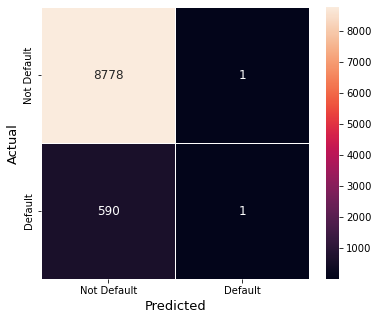

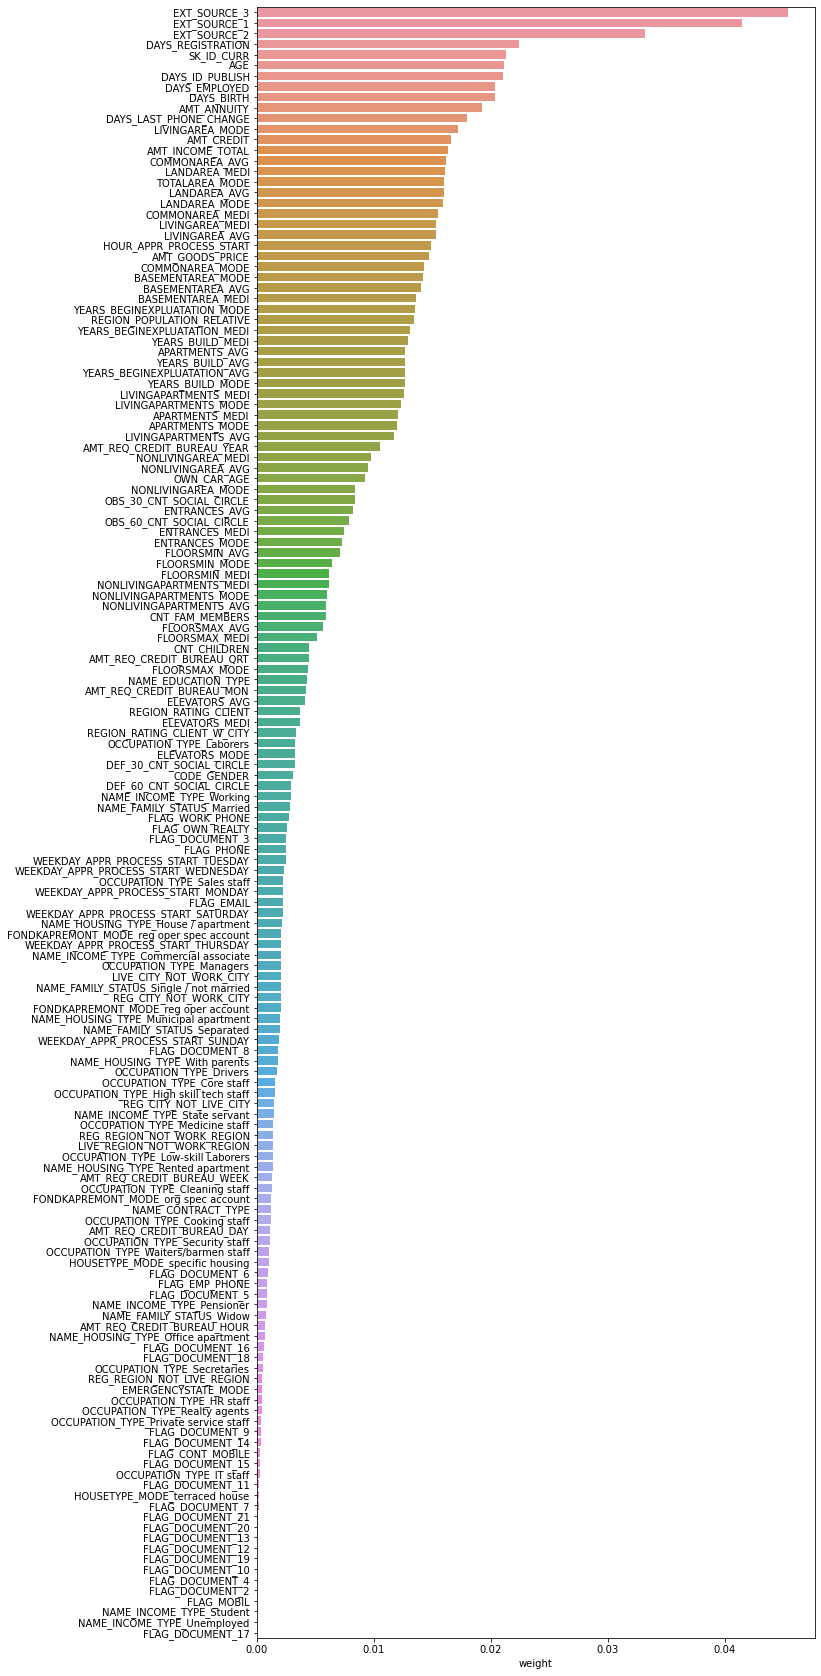

In [290]:
rf = RandomForestClassifier(random_state=42)
temp_rf = rf.fit(xtrain, ytrain.values.ravel())
eval_classification(rf, xtrain, ytrain, xtest, ytest)
show_feature_importance(temp_rf, figsize=(10,30))

## **XGBoost**

Accuracy (Test) : 0.94
Accuracy (Train) : 0.99
Precision (Test) : 0.38
Precision (Train) : 1.00
Recall (Test) : 0.04
Recall (Train) : 0.78
F1-Score (Test) : 0.07
F1-Score (Train) : 0.88
ROC_AUC (test-proba) : 0.71
ROC_AUC (train-proba) : 1.00


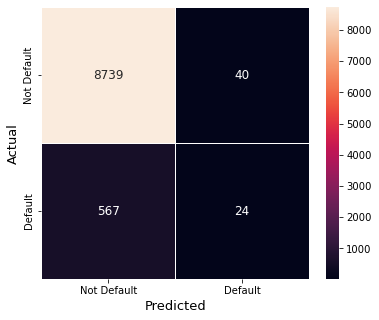

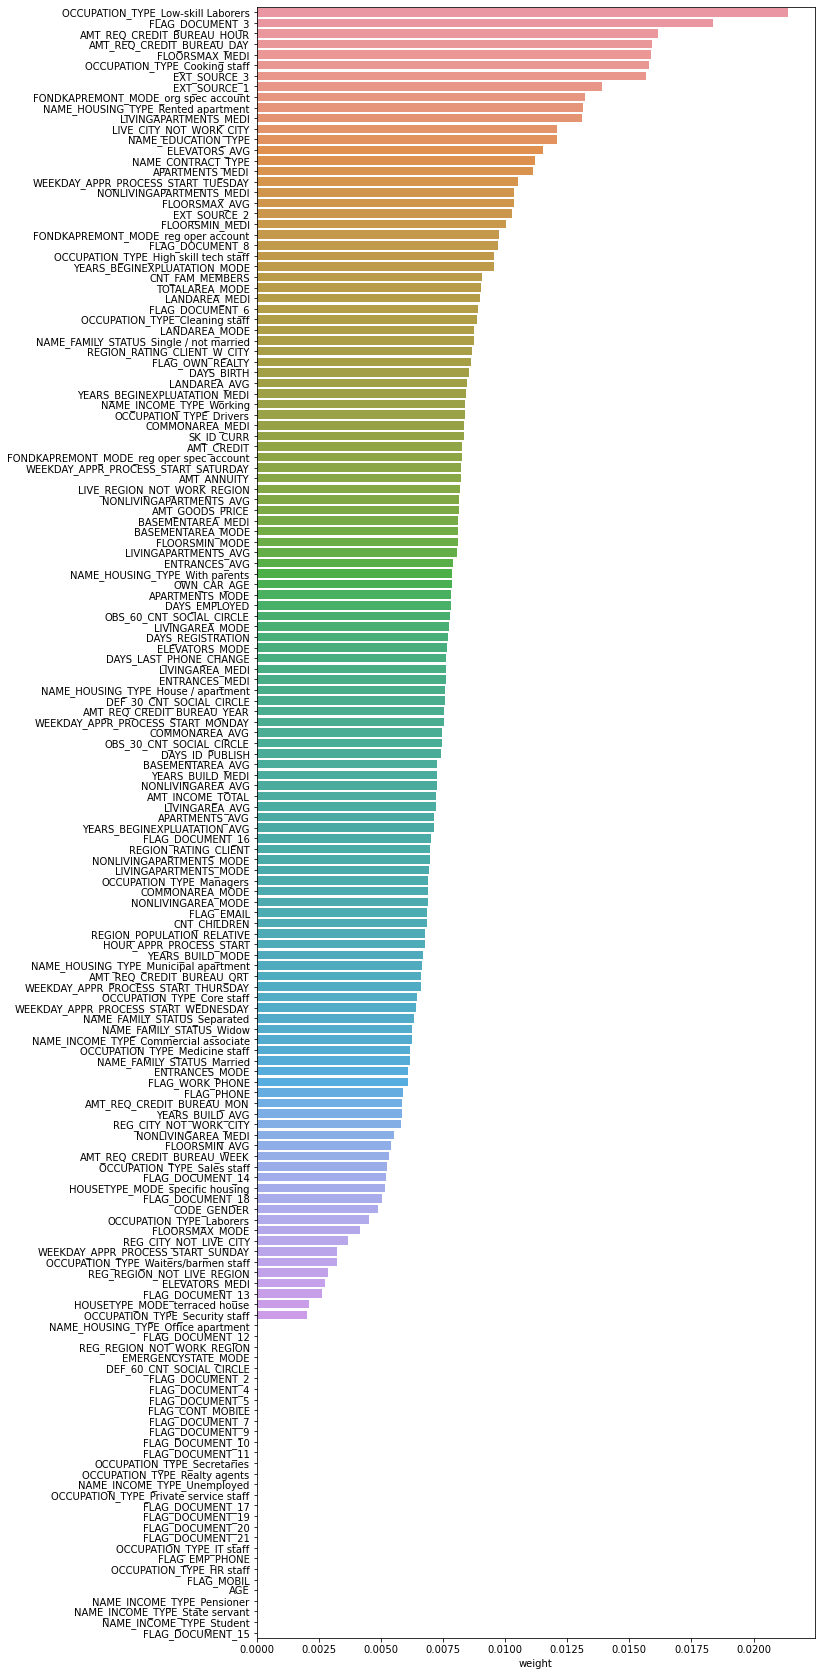

In [298]:
xgb = XGBClassifier(random_state=42)
temp_xgb = xgb.fit(xtrain, ytrain.values.ravel())
eval_classification(xgb, xtrain, ytrain, xtest, ytest)
show_feature_importance(temp_xgb, figsize=(10,30))

## **Logistic Regression**

C:\SYS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy (Test) : 0.94
Accuracy (Train) : 0.93
Precision (Test) : 0.23
Precision (Train) : 0.58
Recall (Test) : 0.01
Recall (Train) : 0.01
F1-Score (Test) : 0.01
F1-Score (Train) : 0.02
ROC_AUC (test-proba) : 0.76
ROC_AUC (train-proba) : 0.78


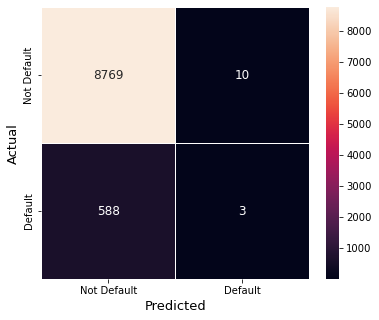

In [297]:
lr = LogisticRegression()
temp_lr = lr.fit(xtrain, ytrain.values.ravel())
eval_classification(temp_lr, xtrain, ytrain, xtest, ytest)

C:\SYS\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy (Test) : 0.71
Accuracy (Train) : 0.73
Precision (Test) : 0.13
Precision (Train) : 0.73
Recall (Test) : 0.64
Recall (Train) : 0.75
F1-Score (Test) : 0.22
F1-Score (Train) : 0.74
ROC_AUC (test-proba) : 0.75
ROC_AUC (train-proba) : 0.81


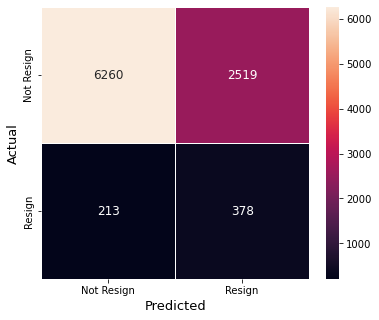

In [277]:
temp_lr = lr.fit(xtrain_balance, ytrain_balance.values.ravel())
eval_classification(temp_lr, xtrain_balance, ytrain_balance, xtest, ytest)